In [56]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

In [2]:
class LSTM(nn.Module):
    def __init__(self, n_hidden=64):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        
        # layers
        self.lstm = nn.LSTMCell(1, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)
        
    def forward(self, x, future=0):
        outputs = []

        # hidden states and cell states
        h_t0 = torch.zeros(x.size(0), self.n_hidden, dtype=torch.float32)
        c_t0 = torch.zeros(x.size(0), self.n_hidden, dtype=torch.float32)
        
        for input_t in x.split(1, dim=1):
            h_t1, c_t1 = self.lstm(input_t, (h_t0, c_t0))
            output = self.linear(h_t1)
            outputs += [output]
            
        for i in range(future):
            h_t1, c_t1 = self.lstm(output, (h_t0, c_t0))
            output = self.linear(h_t1)
            outputs += [output]
            
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [55]:
# DATASET
seq = []
test_seq = [[446., 178.4, 363.936, 271.168, 1784., 80.28, 3568., 579.8],
            [848., 339.2, 691.968, 515.584, 3392., 152.64, 6784., 1102.4], 
            [936., 374.4, 763.776, 569.088, 3744., 168.48, 7488., 1216.8], 
            [1971., 788.4, 1608.336, 1198.368, 7884., 354.78,  15768., 2562.3], 
            [1446., 578.4 ,1179.936, 879.168, 5784., 260.28, 11568., 1879.8], 
            [209., 83.6, 170.544, 127.072, 836., 37.62, 1672., 271.7], 
            [1481., 592.4, 1208.496, 900.448, 5924., 266.58, 11848., 1925.3]]

i = 200
while (i <= 2000):
    # [input, cement, sand, gravel, steel, paint, bricks, flooring]
    seq.append([i, (i * 0.4), (i * 0.816), (i * 0.608), 
                   (i * 4.0), (i * 0.18), (i * 8), (i * 1.3)])
    i += 200

# to numpy    
seq = np.array(seq, dtype=np.float32)
test_seq = np.array(test_seq, dtype=np.float32)

# preproccess
sc = MinMaxScaler(feature_range=(0,1))

sc.fit(seq)
seq = sc.transform(seq)
test_seq = sc.transform(test_seq)

# to tensor
train_x = torch.from_numpy(seq) # ([[10, 8]])
train_y = torch.from_numpy(seq) # ([10, 8])

test_x = torch.from_numpy(test_seq[0:, :1])
test_y = torch.from_numpy(test_seq[0:, :])


print(test_x.shape, test_y.shape)

torch.Size([7, 1]) torch.Size([7, 8])


training...
step 999 / 1000 | Loss in training: 6.881715535200783e-07
step 999 / 1000 | Loss in testing : 1.7601572835701518e-05


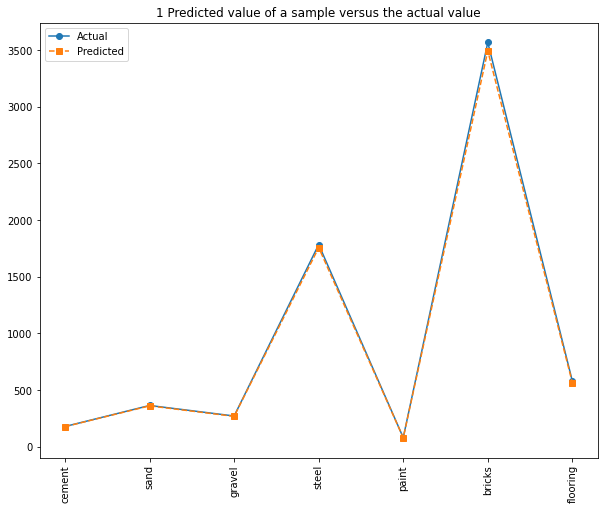

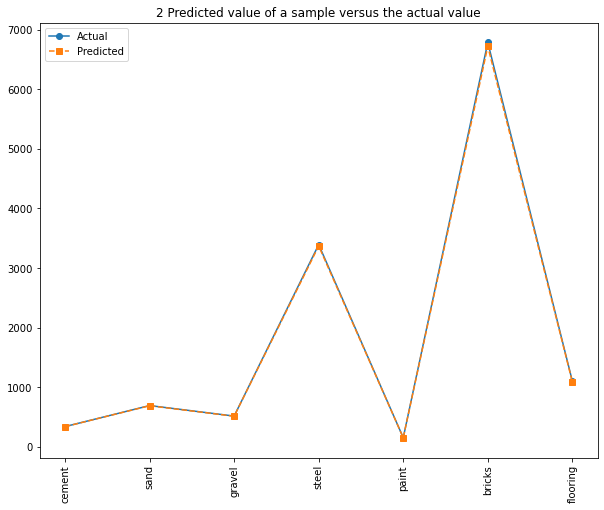

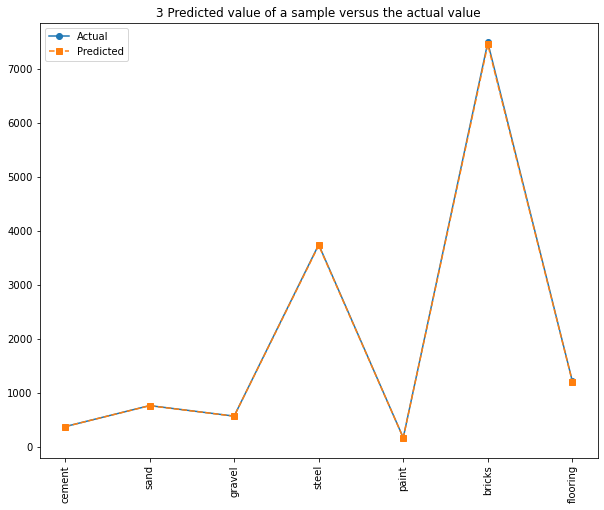

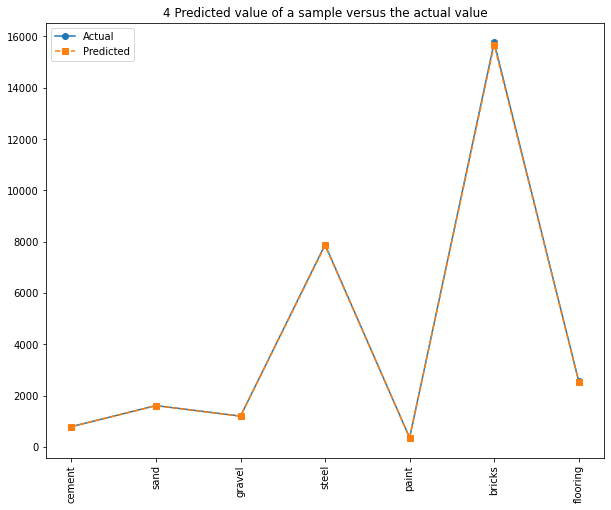

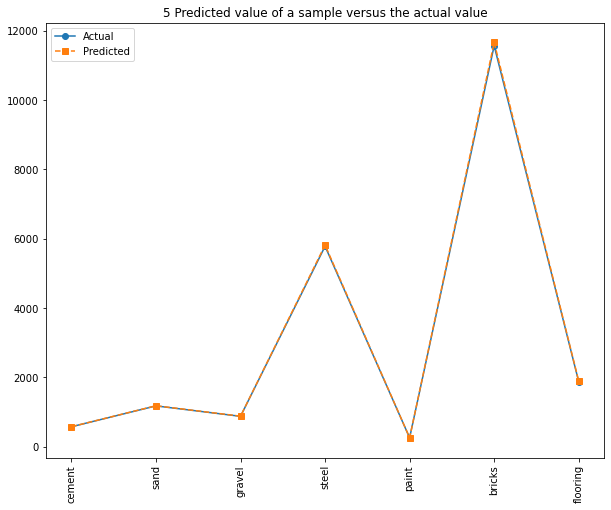

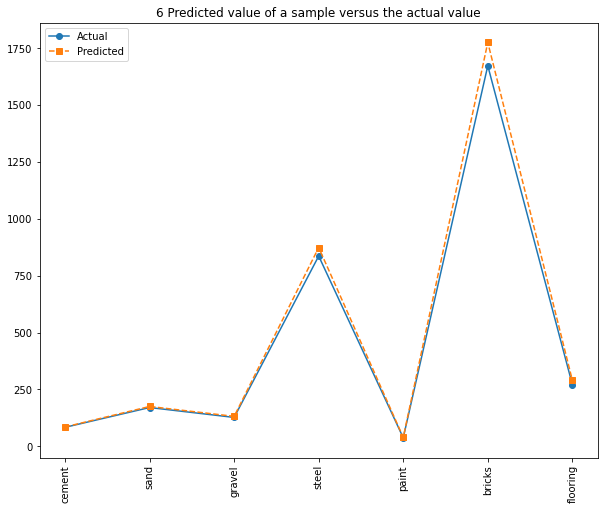

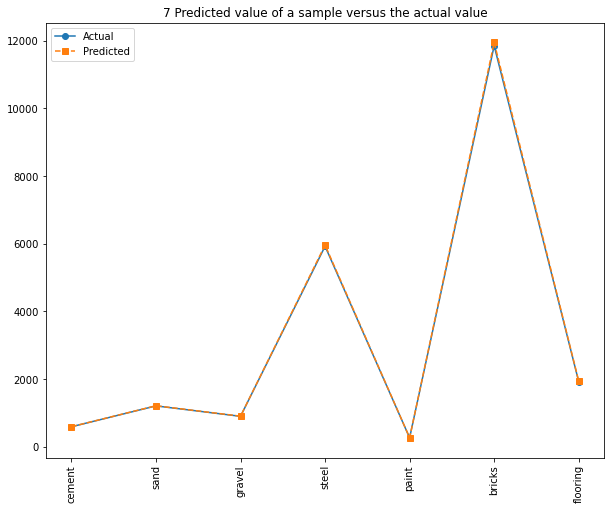

In [47]:
# model params
model = LSTM(n_hidden=52)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_steps = 1000

# training loop
def run_train():
    print('training...')
    for i in range(n_steps):
        
        optimizer.zero_grad()                 # zero the gradient
        out = model(train_x)                  # forward pass
        loss = criterion(out, train_y)        # calculate the loss
        loss.backward()                       # backward pass
        optimizer.step()                      # update parameters

        if i == n_steps - 1:
            print(f"step {i} / {n_steps} | Loss in training: {loss.item()}")
        
                             
        with torch.no_grad():                 # testing
            future = 7
            pred = model(test_x, future)
            loss = criterion(pred, test_y)
            y = pred.detach().numpy()
            
            if i == n_steps - 1:
                print(f"step {i} / {n_steps} | Loss in testing : {loss.item()}")

    
    # scale up values
    y_s = sc.inverse_transform(test_y)
    pred_s = sc.inverse_transform(y)
    
    # plot the values
    y_act = y_s[:, 1:]
    y_pred = pred_s[:, 1:]
    x_ticks = range(len(y_act))
    labels = ['cement', 'sand', 'gravel', 'steel', 'paint', 'bricks', 'flooring']
    
    for i in x_ticks:
        plt.rcParams["figure.figsize"] = (10,8)
        plt.title(f"{i+1} Predicted value of a sample versus the actual value")
        plt.plot(x_ticks, y_act[i], 'o-', label='Actual')
        plt.plot(x_ticks, y_pred[i], 's--', label='Predicted')
        plt.xticks(x_ticks, labels, rotation='vertical')
        plt.legend(loc="upper left")
        plt.show()

    
        
run_train()

In [52]:
# save the model
PATH = 'main_model.pt'
torch.save(model.state_dict(), PATH)

In [54]:
# load and export the model to onnx
input_names = ["actual_input"]
output_names = ["output"]

trained_model = LSTM(n_hidden=52)
trained_model.load_state_dict(torch.load('main_model.pt'))
trained_model.eval()
dummy_input = torch.tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
torch.onnx.export(trained_model, 
                  dummy_input, 
                  'main_model.onnx', 
                  verbose=True,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True)